In [329]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import LineModelND, ransac

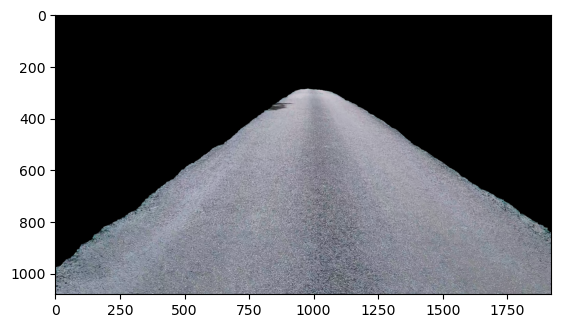

In [330]:
im = cv.imread('/home/thmegy/Téléchargements/road_extract/CC_BHS_logiroad_2_20210531_161706_390_2778.jpg')
plt.imshow(im)

In [331]:
new_im = np.where(im>0, 255, 0).astype('uint8')

kernel = np.ones((5, 5), np.uint8)
erode = cv.erode(new_im, kernel)
dilate = cv.dilate(new_im, kernel)

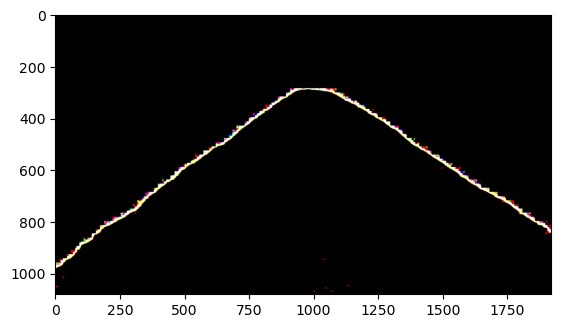

In [332]:
diff = erode-dilate
diff = np.where(diff>0, 255, 0)

plt.imshow(diff)

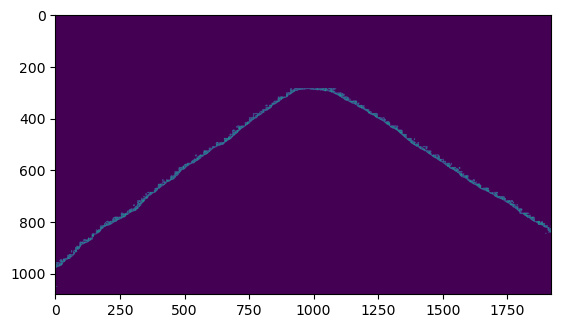

In [333]:
# get edges
gray = cv.cvtColor(new_im,cv.COLOR_BGR2GRAY)
edges = cv.Canny(gray, 50 ,150 ,apertureSize = 3)
plt.imshow(edges)

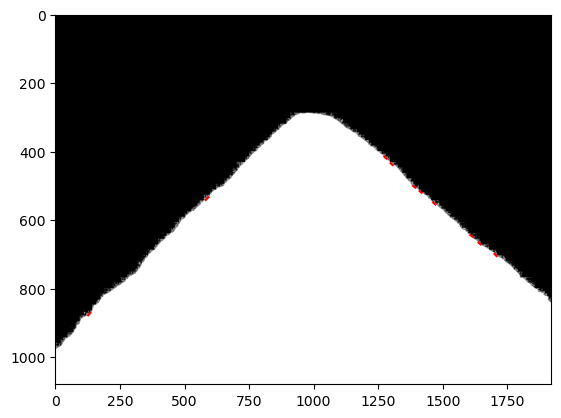

In [334]:
minLineLength = 150
maxLineGap = 8
lines = cv.HoughLinesP(edges,3,np.pi/180,1,minLineLength,maxLineGap)
lines = lines.squeeze()
plt.imshow(gray, aspect="auto", cmap="gray")
for x1, y1, x2, y2 in lines:
    plt.plot([x1, x2], [y1, y2], "r")

In [335]:
#keep only lower part of image
#edges[:150] = 0
# get coordinates of pixels with value > 0
py, px = np.where(edges>0)

pt = np.transpose(np.array([px,py]))

In [336]:
model_robust1, inliers = ransac(pt, LineModelND, min_samples=2,
                               residual_threshold=30, max_trials=1000)

In [337]:
# remove inliers of first line and run second ransac
i = np.where(np.logical_not(inliers))[0]
pt2 = pt[i,:]
model_robust2, inliers = ransac(pt2, LineModelND, min_samples=2,
                                   residual_threshold=20, max_trials=1000)

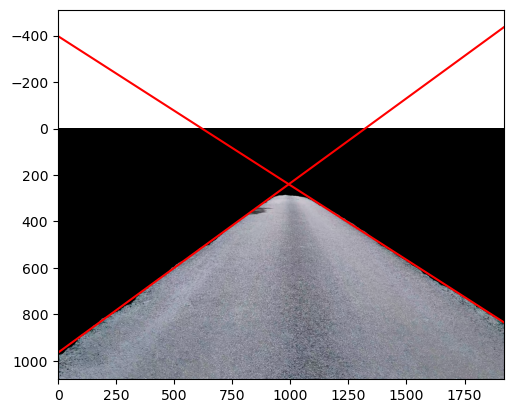

In [338]:
# plot estimated model
line_x = np.arange(0, 1920)
line_y_robust1 = model_robust1.predict_y(line_x)
line_y_robust2 = model_robust2.predict_y(line_x)
plt.imshow(im)
plt.plot(line_x, line_y_robust1, color='red')
plt.plot(line_x, line_y_robust2, color='red')

In [339]:
origin1, direction1 = model_robust1.params
a2 = direction1[0] / direction1[1]
b2 = origin1[0] - a2*origin1[1]

In [340]:
origin2, direction2 = model_robust2.params
a1 = direction2[0] / direction2[1]
b1 = origin2[0] - a1*origin2[1]

In [341]:
line_y = np.arange(0, 1080)
line_x_middle = 0.5 * ((a2-a1)*line_y + b2-b1) + a1*line_y + b1
line_x_bdr_ll = 0.115 * ((a2-a1)*line_y + b2-b1) + a1*line_y + b1 # left side of left BDR
line_x_bdr_rl = 0.345 * ((a2-a1)*line_y + b2-b1) + a1*line_y + b1 # right side of left BDR
line_x_bdr_lr = 0.655 * ((a2-a1)*line_y + b2-b1) + a1*line_y + b1 # left side of right BDR
line_x_bdr_rr = 0.885 * ((a2-a1)*line_y + b2-b1) + a1*line_y + b1 # right side of right BDR

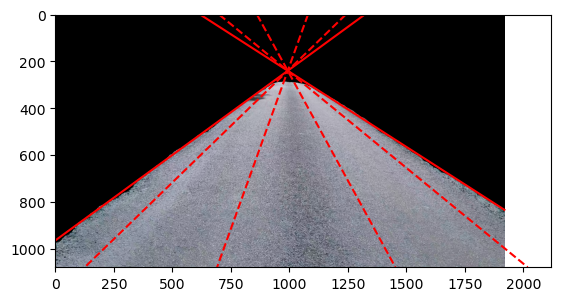

In [342]:
plt.imshow(im)
plt.plot(line_x[line_y_robust1>0], line_y_robust1[line_y_robust1>0], color='red')
plt.plot(line_x[line_y_robust2>0], line_y_robust2[line_y_robust2>0], color='red')
plt.plot(line_x_bdr_ll[line_x_bdr_ll>0], line_y[line_x_bdr_ll>0], color='red', linestyle='dashed')
plt.plot(line_x_bdr_rl[line_x_bdr_rl>0], line_y[line_x_bdr_rl>0], color='red', linestyle='dashed')
plt.plot(line_x_bdr_lr[line_x_bdr_lr<1920], line_y[line_x_bdr_lr<1920], color='red', linestyle='dashed')
plt.plot(line_x_bdr_rr[line_x_bdr_rr<1920], line_y[line_x_bdr_rr<1920], color='red', linestyle='dashed')